![](img/taxi.jpg)


# Objective

- Develop a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables


## Task:
- Investigate the variables that influence the duration of the trip.
- Based on individual trip attributes, predict the duration of each trip in the test set.
- Other additional analysis

## Data source (stage 1):

- Taxi trip data provided

## Data source (stage 2, future work)
- External data soruce - Weather data in NYC
- External data source - OSRM data in NYC

## Data field

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

## evaluation metric

- Root mean square error (RMSE) on trip duration 


## 1) import the necessary package

In [148]:
import numpy as np 
import pandas as pd 
from datetime import timedelta
import datetime as dt

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

from math import sqrt

import xgboost as xgb
from sklearn.metrics import explained_variance_score

import lightgbm as lgb
import joblib
import gmplot 

import folium
from folium import plugins


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [24, 10]



In [2]:
## read input data
train = pd.read_csv('nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('nyc-taxi-trip-duration/test.csv')
sample_submission = pd.read_csv('nyc-taxi-trip-duration/sample_submission.csv')

In [3]:
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [4]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [5]:
## check null value

train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

- good to know there is no null or missing value in the dataset

In [6]:
## statistic summary

train.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01      4.073588e+01   3.970000e+02  
50%        -7.397975e+01      4.075452e+01   6.620000e+02  
75%        -7.396301e+01      4.076981e+01   1.075000e+03  
max        -6.133553e+01      4.392103e+01   3.526282e+06

In [7]:
## show column data type info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


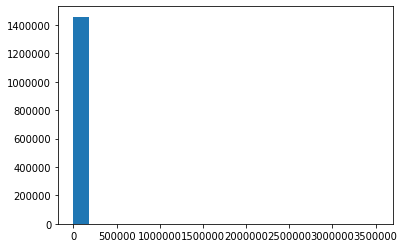

In [8]:
## plot histogram
plt.hist(train['trip_duration'].values, bins=20)
plt.show()

The trip duration have a huge range of number (from 1 seconds to 3,526,282 seconds ( or 977 hours), lets do some log transformation



In [9]:
## apply log10 transformation
train['log_trip_duration'] = np.log10(train['trip_duration'].values)

train['trip_duration_minutes'] = train['trip_duration']/60
train['log_trip_duration_minutes'] = np.log10(train['trip_duration_minutes'].values)


plt.hist(train['log_trip_duration_minutes'].values, bins=100)
plt.xlabel('log10 of trip_duration(minutes)')
plt.ylabel('number of records ')
plt.show()

we can see the distrubtion center at log10 = 3, which is 1000 seconds or 16.7 minutes in average per trip 

In [10]:
## set text display so we can 
pd.options.display.float_format = "{:.2f}".format

train['trip_duration_minutes'].describe()

count   1458644.00
mean         15.99
std          87.29
min           0.02
25%           6.62
50%          11.03
75%          17.92
max       58771.37
Name: trip_duration_minutes, dtype: float64

In [11]:
# ## box plot
# sns.boxplot(x='vendor_id',y='log_trip_duration',data=train)


## extract additional date & time feature

In [12]:
## change to proper date data format 
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

In [67]:
# extract Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

## extract day of the month
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day

## extarct day of week
train['dayofweek'] = train['pickup_datetime'].dt.strftime('%A')
test['dayofweek'] = test['pickup_datetime'].dt.strftime('%A') ## convert into day name

## extract hour
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour


## 2) exploratory data analysis

### 2.1 number of trips over the time

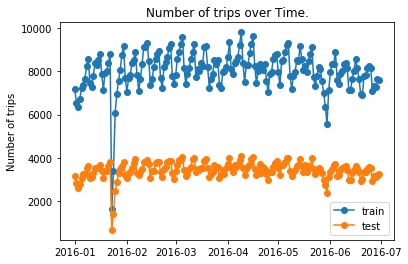

In [14]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Number of trips over Time.')
plt.legend(loc=0)
plt.ylabel('Number of trips')
plt.show()

Both train and test data follow the same pattern over the time. There are some interesting point

- In late Jan 2016, there are sharp fall on the trips number, it could be relate to winter season or festival. However it happen to short period, it might be worth noting on this discrepancy, perhaps it might be caused by data system error or other factor 

In [15]:
train['pickup_date'].value_counts().tail()

2016-01-03    6353
2016-01-25    6084
2016-05-30    5570
2016-01-24    3383
2016-01-23    1648
Name: pickup_date, dtype: int64

## 2.2 pick up location map visualization

In [16]:
import pandas as pd 
import folium
from folium.plugins import HeatMap

map_center = train.pickup_latitude.mean() , train.pickup_longitude.mean()
latitudes = train.pickup_latitude[:30000]  ## take n sample
longitudes = train.pickup_longitude[:30000]


hmap = folium.Map(location=map_center, zoom_start=11, )

hm_wide = HeatMap( list(zip(latitudes.values, longitudes.values )),
                   min_opacity=0.2,
                   radius=8, blur=15, 
                   max_zoom=7, 
                 )

## change radius to set the heatmap density and color

hmap.add_child(hm_wide)

In [17]:
## save the heatmap
hmap.save('nyt_heatmap_30k_pickup_train.html')


In [18]:
### check 

In [19]:
## dropoff location heatmap

map_center = train.dropoff_latitude.mean() , train.dropoff_longitude.mean()
latitudes = train.dropoff_latitude[:30000]  ## take n sample
longitudes = train.dropoff_longitude[:30000]


hmap = folium.Map(location=map_center, zoom_start=11, )

hm_wide = HeatMap( list(zip(latitudes.values, longitudes.values )),
                   min_opacity=0.2,
                   radius=8, blur=15, 
                   max_zoom=7, 
                 )

## change radius to set the heatmap density and color

hmap.add_child(hm_wide)

In [20]:
## save the heatmap
hmap.save('nyt_heatmap_30k_dropoff_train.html')


KeyError: 'pickup_cluster'

In [ ]:
train['pickup_dropoff_cluster'].value_counts()

- we the box 

In [ ]:
## box plot
sns.boxplot(x='pickup_cluster',y='log_trip_duration',data=train)


In [ ]:
## box plot
sns.boxplot(x='dropoff_cluster',y='log_trip_duration',data=train)


## 2.3 Function to calculate distance ( from the pick-up to drop-off pont) & direction

### Haversine distance

The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Important in navigation, it is a special case of a more general formula in spherical trigonometry, the law of haversines, that relates the sides and angles of spherical triangles.

Formula:
![](img/haversine_formula.svg)

reference: https://en.wikipedia.org/wiki/Haversine_formula


- First we calculate haversine distance, which is the great-circle distance between two points on a sphere given their longitudes and latitudes.

- then we calculate the summed distance traveled in Manhattan. 

- Finally we calculate the direction (or bearing) of the distance traveled using trigonmetry


In [116]:

## calculate distance using haversine and manhattan distance

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km, default value
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [117]:
## pick-up location
train_lat1 = train['pickup_latitude'].values
train_lng1 = train['pickup_longitude'].values
test_lat1 = test['pickup_latitude'].values
test_lng1 = test['pickup_longitude'].values

## drop-off coordinate
train_lat2 = train['dropoff_latitude'].values
train_lng2 =  train['dropoff_longitude'].values
test_lat2 = test['dropoff_latitude'].values
test_lng2 = test['dropoff_longitude'].values

## apply distance calculation
train.loc[:, 'distance_haversine'] = haversine_array( train_lat1, train_lng1 , train_lat2 , train_lng2)
test.loc[:, 'distance_haversine'] = haversine_array( test_lat1, test_lng1 , test_lat2 , test_lng2)
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train_lat1, train_lng1 , train_lat2 , train_lng2)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance( test_lat1, test_lng1 , test_lat2 , test_lng2)
    
    
train.loc[:, 'direction'] = bearing_array(train_lat1, train_lng1 , train_lat2 , train_lng2)
test.loc[:, 'direction'] = bearing_array( test_lat1, test_lng1 , test_lat2 , test_lng2)

In [118]:
train['distance_haversine'].describe()

count   1458644.00
mean          3.44
std           4.30
min           0.00
25%           1.23
50%           2.09
75%           3.88
max        1240.91
Name: distance_haversine, dtype: float64

In [ ]:
ax = sns.lineplot(x="dayofweek", y="trip_duration_minutes", hue = 'vendor_id', style = 'vendor_id', data=train)
ax.set_title('trip duration (minutes) by day-of-week & vendor')
ax

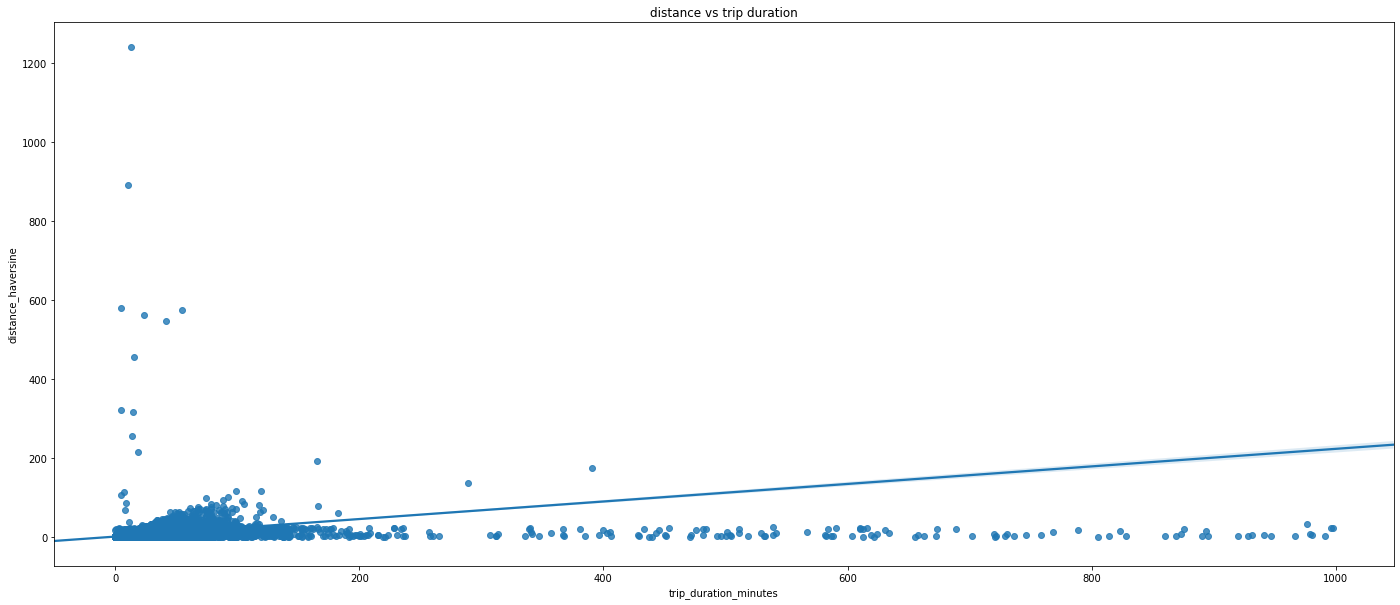

In [157]:
## selected train

selected_df = train[train['trip_duration_minutes']<1000].reset_index(drop  = True)

## line plot on pickup cluster vs trip duration
ax = sns.regplot(x="trip_duration_minutes", y="distance_haversine", data= selected_df)
ax.set_title('distance vs trip duration')
ax

- distance itself alone doesn't fit in quite well here, we need to calculate the speed and the traffic condition to give a better estimation on the total trip duration


## 2.3b  Function to calculate speed of travel

In [159]:
## apply speed function ( speed = total distance / duration )
train.loc[:, 'avg_speed_h'] = train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = train['distance_dummy_manhattan'] / train['trip_duration']

## apply speed function ( speed = total distance / duration )
test.loc[:, 'avg_speed_h'] = test['distance_haversine'] / train['trip_duration']
test.loc[:, 'avg_speed_m'] = test['distance_dummy_manhattan'] / train['trip_duration']

## 2.4 explore categorical variable

In [12]:
## selected categorical variable
cat_columns= [ 'vendor_id', 'store_and_fwd_flag', 'Month', 'DayofMonth', 'dayofweek', 'Hour' ]

## change data-type to category for further processing
train[cat_columns] = train[cat_columns].astype('category')

test[cat_columns] = test[cat_columns].astype('category')

In [48]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 14 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null datetime64[ns]
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
pickup_date           625134 non-null object
Month                 625134 non-null int64
DayofMonth            625134 non-null int64
dayofweek             625134 non-null int64
Hour                  625134 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(6), object(3)
memory usage: 66.8+ MB


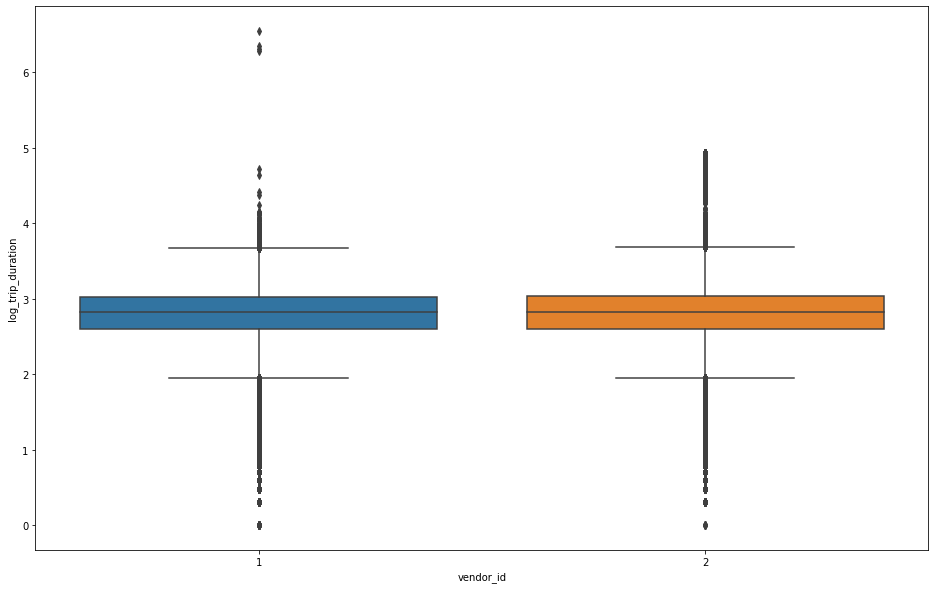

In [14]:
## box plot
sns.boxplot(x='vendor_id',y='log_trip_duration',data=train)


In [49]:
train.vendor_id

0          2
1          1
2          2
3          2
4          2
          ..
1458639    2
1458640    1
1458641    2
1458642    1
1458643    1
Name: vendor_id, Length: 1458644, dtype: int64

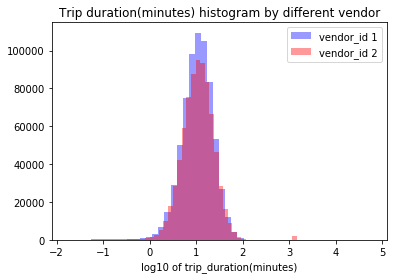

In [75]:
# distirbution plot on 2 different set

data1 = train[ train["vendor_id"]== 1].reset_index(drop = True)
data2 = train[ train["vendor_id"]== 2].reset_index(drop = True)

sns.distplot( data1['log_trip_duration_minutes'] ,  kde=False, color="blue", label="vendor_id 1")
sns.distplot( data2['log_trip_duration_minutes']  , kde=False, color="red", label="vendor_id 2")
plt.legend()
plt.title('Trip duration(minutes) histogram by different vendor')
# plt.xscale()
plt.xlabel('log10 of trip_duration(minutes)')
plt.show()


In [86]:
train.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1            -73.98            40.77             -73.96   
1                1            -73.98            40.74             -74.00   
2                1            -73.98            40.76             -74.01   
3                1            -74.01            40.72             -74.01   
4                1            -73.97            40.79             -73.97   

   dropoff_latitude store_and_fwd_flag  trip_duration  log_trip_duration  \
0             40.77                  N            455               2.66   
1             40.73                  N            663               2.82   
2             40.71                  N           2124               3.33   
3             40.71                  N            429               2.63   
4             40.78                  N            435               2.64   

   trip_duration_minutes  log_trip_duration_minutes pickup_date  Month  \
0                   7.58                       0.88  2016-03-14      3   
1                  11.05                       1.04  2016-06-12      6   
2                  35.40                       1.55  2016-01-19      1   
3                   7.15                       0.85  2016-04-06      4   
4                   7.25                       0.86  2016-03-26      3   

   DayofMonth  dayofweek  Hour  
0          14          0    17  
1          12          6     0  
2          19          1    11  
3           6          2    19  
4          26          5    13

In [90]:
train.trip_duration_minutes.describe()

count   1456683.00
mean         14.00
std          12.29
min           0.02
25%           6.62
50%          11.03
75%          17.88
max         997.48
Name: trip_duration_minutes, dtype: float64

In [91]:
# import plotly.express as px

# fig = px.line( train, x="Hour", y="trip_duration_minutes", color='Month')
# fig.show()

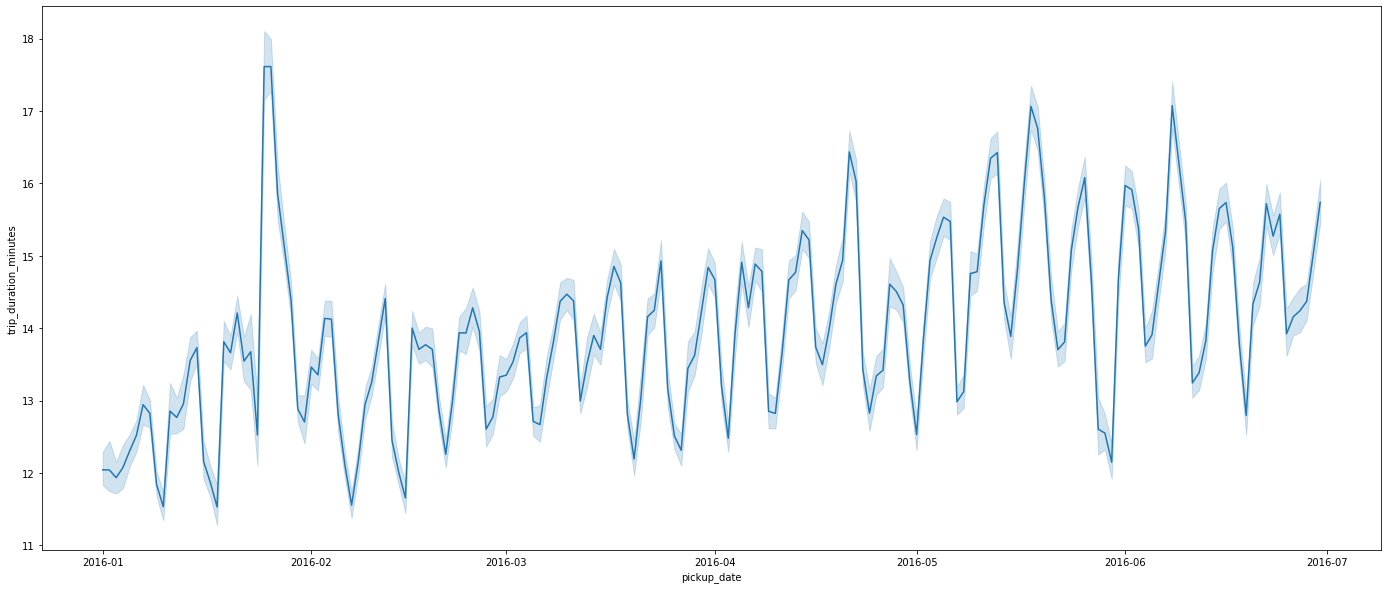

In [98]:
ax = sns.lineplot(x="pickup_date", y="trip_duration_minutes", data=train)
ax.set_title('trip duration minutes by date')
ax

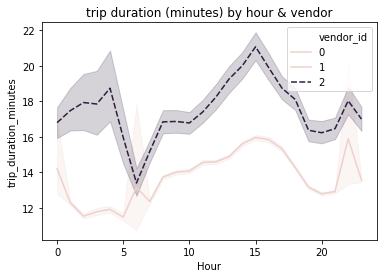

In [69]:
ax = sns.lineplot(x="Hour", y="trip_duration_minutes", hue = 'vendor_id', style = 'vendor_id', data=train)
ax.set_title('trip duration (minutes) by hour & vendor')
ax

In [68]:
ax = sns.lineplot(x="dayofweek", y="trip_duration_minutes", hue = 'vendor_id', style = 'vendor_id', data=train)
ax.set_title('trip duration (minutes) by day-of-week & vendor')
ax

dayofweek  Hour  trip_duration_minutes
0      Monday    17                   7.58
1      Sunday     0                  11.05
2     Tuesday    11                  35.40
3   Wednesday    19                   7.15
4    Saturday    13                   7.25
..        ...   ...                    ...
95  Wednesday    19                   9.93
96   Thursday    23                   7.25
97   Thursday    13                  18.47
98  Wednesday    16                  47.07
99     Friday    10                  12.82

[100 rows x 3 columns]

In [93]:
hourDayDurationMatrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 3 columns):
dayofweek                168 non-null category
Hour                     168 non-null int64
trip_duration_minutes    168 non-null float64
dtypes: category(1), float64(1), int64(1)
memory usage: 3.3 KB


In [95]:
# ## create average trip duration group by day and hour
# hourDayDurationMatrix = pd.DataFrame(  train.groupby(['dayofweek','Hour'])['trip_duration_minutes'].mean().reset_index() )

# hourDayDurationMatrix.dayofweek = hourDayDurationMatrix.dayofweek.astype('category')

# ## hour vs weekday heamtap
# ax = sns.heatmap( hourDayDurationMatrix, cmap="YlGnBu")


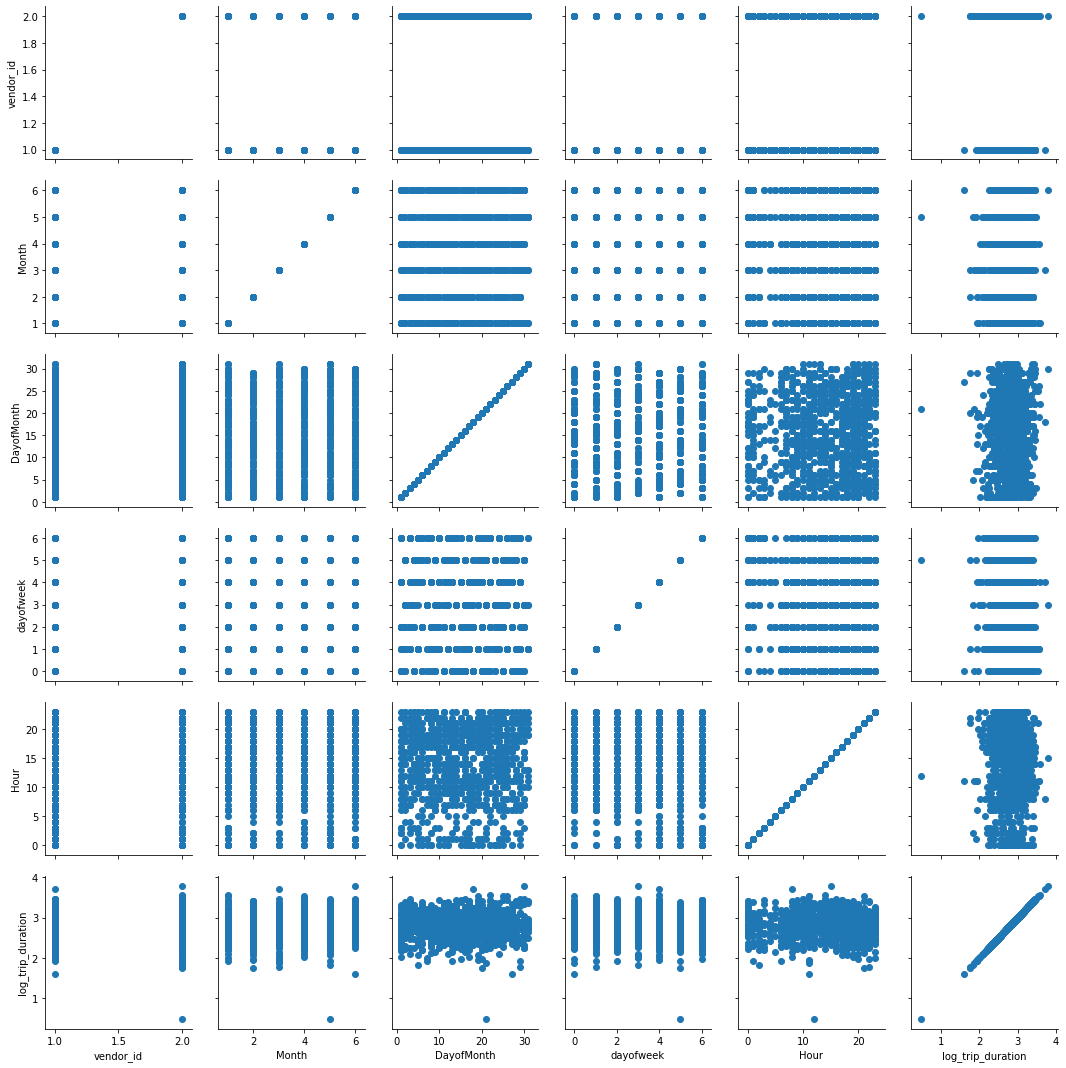

In [85]:

### sns pairplot to visualize all variable

# selected_df = train[ ['vendor_id', 'store_and_fwd_flag', 'Month', 'DayofMonth', 'dayofweek', 'Hour','log_trip_duration'] ]

# g = sns.PairGrid( selected_df[:1000])
# g.map(plt.scatter);

In [80]:
sns.boxplot(x='dayofweek',y='avg_speed_h',data=train)


ValueError: Could not interpret input 'avg_speed_h'

## correlation heatmap

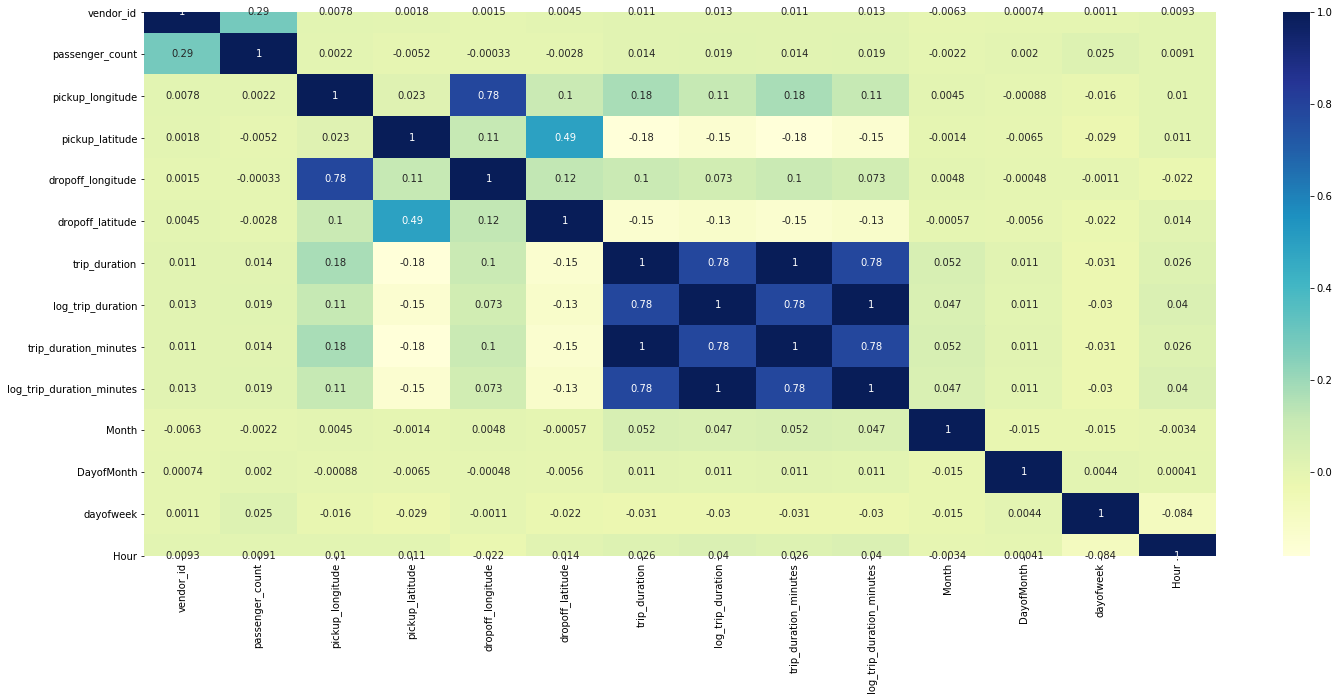

In [112]:
corr = train.corr()

ax = sns.heatmap(corr, annot=True, cmap="YlGnBu")


## Find the Neightbourhood using clustering on cooridinates

In [38]:
train['pickup_latitude'].append( train['dropoff_latitude'])

0         40.77
1         40.74
2         40.76
3         40.72
4         40.79
           ... 
1458639   40.74
1458640   40.80
1458641   40.71
1458642   40.76
1458643   40.79
Length: 2917288, dtype: float64

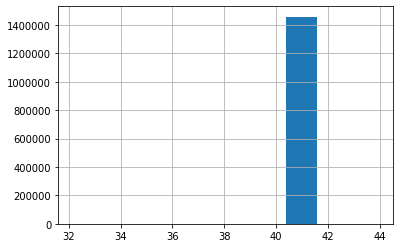

In [31]:
train['dropoff_latitude'].hist()

In [55]:
## append pickup and dropoff location latitude and create new dataframe

latitude = pd.DataFrame ( train['pickup_latitude'].append( train['dropoff_latitude']) )
longitude = pd.DataFrame (train['pickup_longitude'].append(train['dropoff_longitude']) )

In [57]:
## Elbow method to determine the number of cluster

K_clusters = range(1,10) 
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = train[['pickup_latitude']] 
X_axis = train[['pickup_longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

- we can see the elbow method suggest k=6 , where the score curve flatten and any additional cluster will not help

In [98]:

## initiate the k-means model
kmeans = KMeans(n_clusters = 6, init ='k-means++')
kmeans.fit( latitude, longitude) # Compute k-means clustering.
centers = kmeans.cluster_centers_ # Centroid coordinates of cluster


## predict the label
train['pickup_cluster'] = kmeans.predict( train[['pickup_longitude','pickup_latitude']])


train['dropoff_cluster'] = kmeans.predict( train[['dropoff_longitude','dropoff_latitude']])


In [23]:
# ## apply prediction on kaggle test dataset
# test['pickup_cluster'] = kmeans.fit_predict( test[['pickup_longitude','pickup_latitude']])


In [130]:
## centroid coordinates of the cluster
kmeans.cluster_centers_

array([[ -73.98414477,   40.75323209],
       [-121.93332672,   37.38937378],
       [ -73.95526545,   40.78508892],
       [ -73.99393785,   40.71242244],
       [ -73.83721938,   40.72355993],
       [ -67.49679565,   48.85759735]])

In [101]:
train.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1            -73.98            40.77             -73.96   
1                1            -73.98            40.74             -74.00   
2                1            -73.98            40.76             -74.01   
3                1            -74.01            40.72             -74.01   
4                1            -73.97            40.79             -73.97   

   dropoff_latitude store_and_fwd_flag  ...  log_trip_duration  \
0             40.77                  N  ...               2.66   
1             40.73                  N  ...               2.82   
2             40.71                  N  ...               3.33   
3             40.71                  N  ...               2.63   
4             40.78                  N  ...               2.64   

   trip_duration_minutes  log_trip_duration_minutes  pickup_date Month  \
0                   7.58                       0.88   2016-03-14     3   
1                  11.05                       1.04   2016-06-12     6   
2                  35.40                       1.55   2016-01-19     1   
3                   7.15                       0.85   2016-04-06     4   
4                   7.25                       0.86   2016-03-26     3   

   DayofMonth  dayofweek Hour  pickup_cluster  dropoff_cluster  
0          14     Monday   17               0                2  
1          12     Sunday    0               1                0  
2          19    Tuesday   11               0                0  
3           6  Wednesday   19               1                0  
4          26   Saturday   13               0                2  

[5 rows x 21 columns]

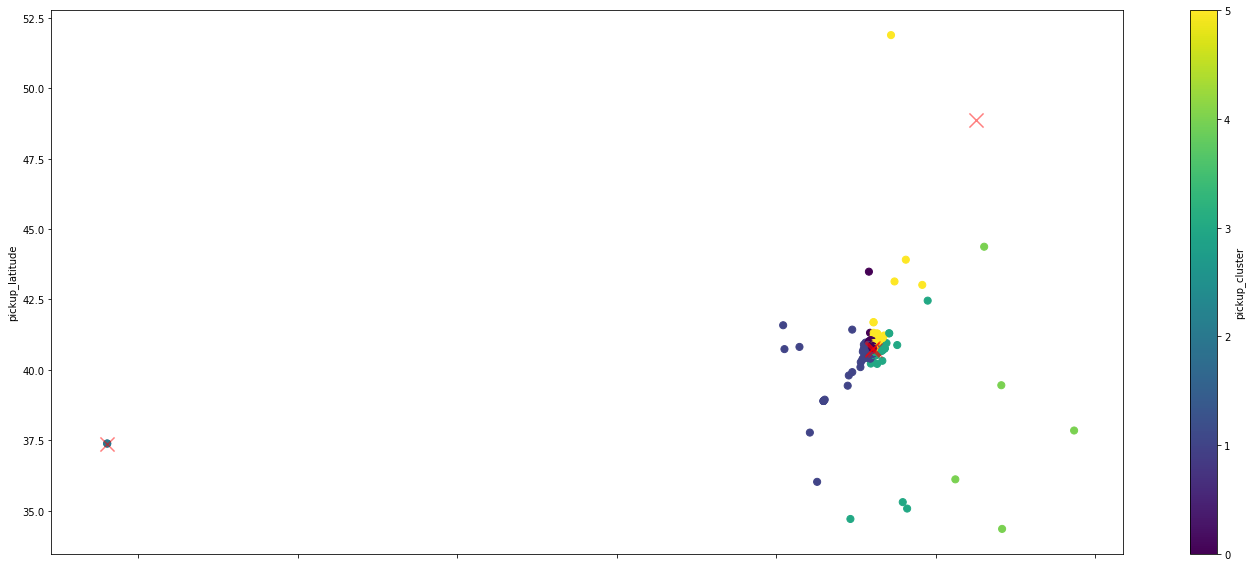

In [132]:
## get centroid cooridnates
centers = kmeans.cluster_centers_

## visualize the cluster & centroid
# train.plot.scatter(x = 'pickup_longitude', y = 'pickup_latitude', c='pickup_cluster', s=50, cmap='viridis') ## data point coordinate

train.plot.scatter(x = 'pickup_longitude', y = 'pickup_latitude', c='pickup_cluster', s=50, cmap='viridis') ## data point coordinate

plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5 , marker='x') 
plt.show()

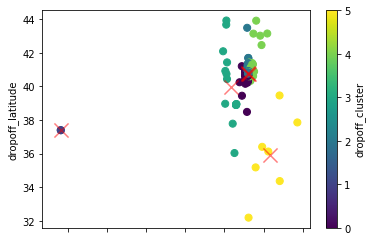

In [104]:
## get centroid cooridnates
centers = kmeans.cluster_centers_

## visualize the cluster & centroid
train.plot.scatter(x = 'dropoff_longitude', y = 'dropoff_latitude', c='dropoff_cluster', s=50, cmap='viridis') ## data point coordinate
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5 , marker='x') 
plt.show()

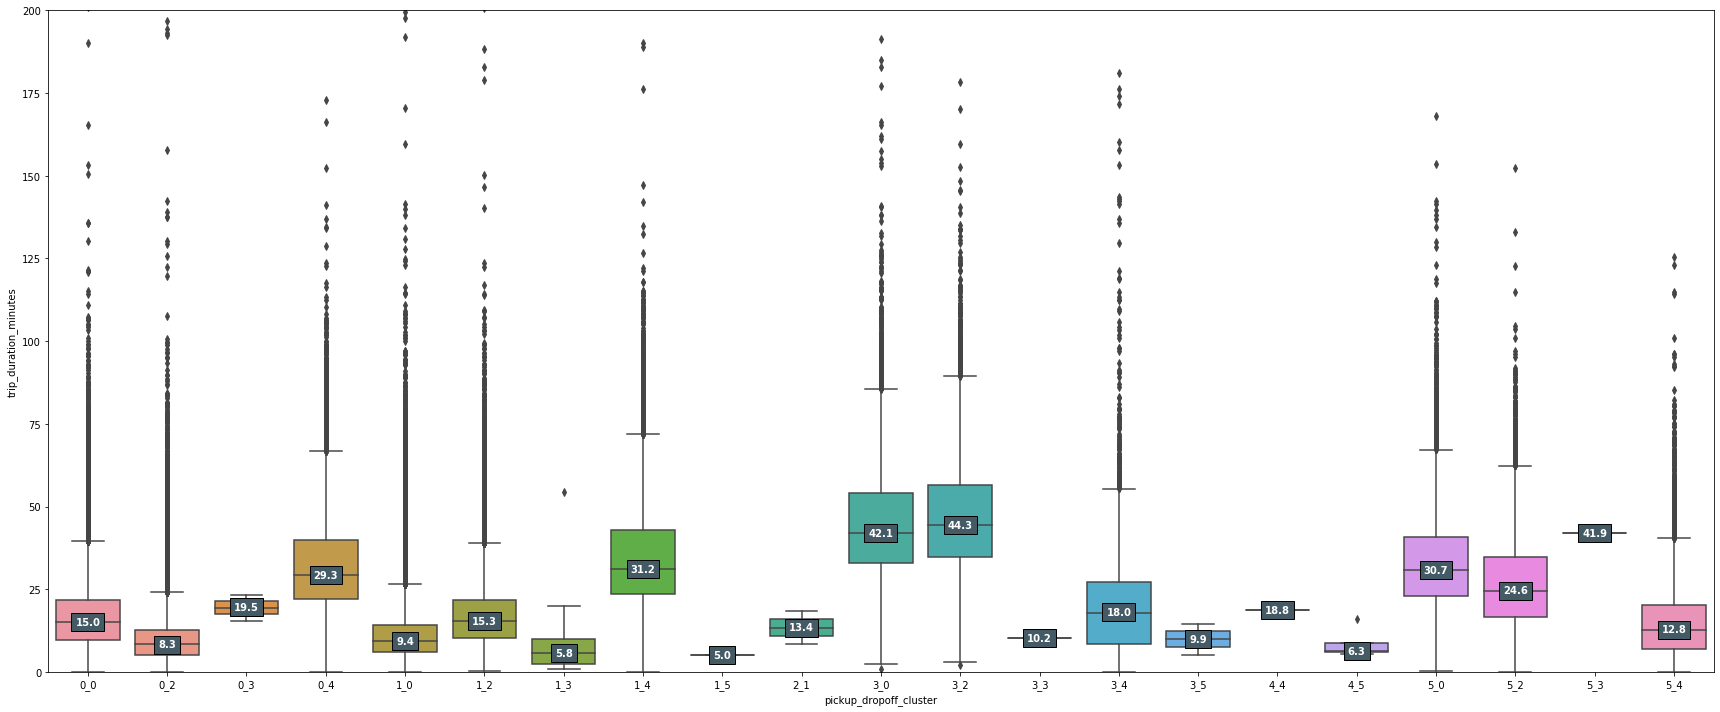

In [129]:
## set plot figure size
plt.rcParams['figure.figsize'] = [24, 10]


## box plot
box_plot = sns.boxplot(x='pickup_dropoff_cluster',y='trip_duration_minutes',data=train)
box_plot.set_ylim([0, 200])


ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))

box_plot.figure.tight_layout()



In [127]:
# ## check at actual map

# ## dropoff location heatmap

# latitudes = centers[:, 0] ## take n sample
# longitudes = centers[:, 1]


# hmap = folium.Map(location=map_center, zoom_start=11, )

# hm_wide = HeatMap( list(zip(latitudes, longitudes )),
#                    min_opacity=1,
#                    radius=8, blur=15, 
#                    max_zoom=7, 
#                  )

# ## change radius to set the heatmap density and color

# hmap.add_child(hm_wide)


In [105]:
## apply prediction on kaggle test dataset
test['pickup_cluster'] = kmeans.fit_predict( test[['pickup_longitude','pickup_latitude']])
test['dropoff_cluster'] = kmeans.fit_predict( test[['dropoff_longitude','dropoff_latitude']])


In [106]:
## add in pickup to dropoff pair combination


train['pickup_dropoff_cluster'] = train['pickup_cluster'].astype(str) + '_' +  train['dropoff_cluster'].astype(str)
test['pickup_dropoff_cluster'] = test['pickup_cluster'].astype(str) + '_' +  test['dropoff_cluster'].astype(str)


In [107]:
### save the dataset

train.to_csv('nyc-taxi-trip-duration/train_v2.csv', index = False)
test.to_csv('nyc-taxi-trip-duration/test_v2.csv', index = False)

In [108]:
# save the model to disk
filename = 'model/kmeans.sav'
joblib.dump(kmeans, filename)

['model/kmeans.sav']

### 3.1 Handle categorical variable + create dummy categorical data 

In [133]:
## selected categorical variable
cat_columns= [ 'vendor_id', 'store_and_fwd_flag', 'Month', 'DayofMonth', 'dayofweek', 'Hour'
              , 'pickup_dropoff_cluster']

## change data-type to category for further processing
train[cat_columns] = train[cat_columns].astype('category')
test[cat_columns] = test[cat_columns].astype('category')

In [134]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'trip_duration_minutes',
       'log_trip_duration_minutes', 'pickup_date', 'Month', 'DayofMonth',
       'dayofweek', 'Hour', 'pickup_cluster', 'dropoff_cluster',
       'pickup_dropoff_cluster', 'distance_haversine',
       'distance_dummy_manhattan', 'direction'],
      dtype='object')

In [111]:
## create dummy data
train_cat_dummy = pd.get_dummies(train[cat_columns], prefix_sep='_')

test_cat_dummy = pd.get_dummies(test[cat_columns], prefix_sep='_')

In [135]:
train_cat_dummy

vendor_id_1  vendor_id_2  store_and_fwd_flag_N  store_and_fwd_flag_Y  \
0                  0            1                     1                     0   
1                  1            0                     1                     0   
2                  0            1                     1                     0   
3                  0            1                     1                     0   
4                  0            1                     1                     0   
...              ...          ...                   ...                   ...   
1458639            0            1                     1                     0   
1458640            1            0                     1                     0   
1458641            0            1                     1                     0   
1458642            1            0                     1                     0   
1458643            1            0                     1                     0   

         Month_1  Month_2  Month_3  Month_4  Month_5  Month_6  ...  \
0              0        0        1        0        0        0  ...   
1              0        0        0        0        0        1  ...   
2              1        0        0        0        0        0  ...   
3              0        0        0        1        0        0  ...   
4              0        0        1        0        0        0  ...   
...          ...      ...      ...      ...      ...      ...  ...   
1458639        0        0        0        1        0        0  ...   
1458640        1        0        0        0        0        0  ...   
1458641        0        0        0        1        0        0  ...   
1458642        1        0        0        0        0        0  ...   
1458643        0        0        0        1        0        0  ...   

         pickup_dropoff_cluster_3_2  pickup_dropoff_cluster_3_3  \
0                                 0                           0   
1                                 0                           0   
2                                 0                           0   
3                                 0                           0   
4                                 0                           0   
...                             ...                         ...   
1458639                           0                           0   
1458640                           0                           0   
1458641                           0                           0   
1458642                           0                           0   
1458643                           0                           0   

         pickup_dropoff_cluster_3_4  pickup_dropoff_cluster_3_5  \
0                                 0                           0   
1                                 0                           0   
2                                 0                           0   
3                                 0                           0   
4                                 0                           0   
...                             ...                         ...   
1458639                           0                           0   
1458640                           0                           0   
1458641                           0                           0   
1458642                           0                           0   
1458643                           0                           0   

         pickup_dropoff_cluster_4_4  pickup_dropoff_cluster_4_5  \
0                                 0                           0   
1                                 0                           0   
2                                 0                           0   
3                                 0                           0   
4                                 0                           0   
...                             ...                         ...   
1458639                           0                           0   
1458640                           0              

In [113]:
test_cat_dummy

vendor_id_1  vendor_id_2  store_and_fwd_flag_N  store_and_fwd_flag_Y  \
0                 1            0                     1                     0   
1                 1            0                     1                     0   
2                 1            0                     1                     0   
3                 0            1                     1                     0   
4                 1            0                     1                     0   
...             ...          ...                   ...                   ...   
625129            1            0                     1                     0   
625130            1            0                     1                     0   
625131            1            0                     1                     0   
625132            1            0                     1                     0   
625133            0            1                     1                     0   

        Month_1  Month_2  Month_3  Month_4  Month_5  Month_6  ...  \
0             0        0        0        0        0        1  ...   
1             0        0        0        0        0        1  ...   
2             0        0        0        0        0        1  ...   
3             0        0        0        0        0        1  ...   
4             0        0        0        0        0        1  ...   
...         ...      ...      ...      ...      ...      ...  ...   
625129        1        0        0        0        0        0  ...   
625130        1        0        0        0        0        0  ...   
625131        1        0        0        0        0        0  ...   
625132        1        0        0        0        0        0  ...   
625133        1        0        0        0        0        0  ...   

        pickup_dropoff_cluster_3_0  pickup_dropoff_cluster_3_2  \
0                                0                           0   
1                                0                           0   
2                                0                           0   
3                                0                           0   
4                                1                           0   
...                            ...                         ...   
625129                           0                           0   
625130                           0                           0   
625131                           0                           0   
625132                           0                           0   
625133                           0                           0   

        pickup_dropoff_cluster_3_3  pickup_dropoff_cluster_3_4  \
0                                0                           0   
1                                0                           0   
2                                0                           0   
3                                1                           0   
4                                0                           0   
...                            ...                         ...   
625129                           0                           0   
625130                           0                           0   
625131                           0                           1   
625132                           0                           0   
625133                           0                           0   

        pickup_dropoff_cluster_4_0  pickup_dropoff_cluster_4_3  \
0                                0                           0   
1                                0                           0   
2                                0                           0   
3                                0                           0   
4                                0                           0   
...                            ...                         ...   
625129                           0                           0   
625130                           0                           0   
625131                           0    

In [136]:

## select variable from original data and merge with categorical dummy data
train_master = train[['log_trip_duration', 'distance_dummy_manhattan','distance_haversine','direction']] .join(train_cat_dummy)
test_master = test[['distance_dummy_manhattan','distance_haversine','direction']].join(test_cat_dummy)



In [137]:
train_master.shape

(1458644, 97)

In [138]:
test_master.shape

(625134, 95)

In [139]:
test_master.head()

distance_dummy_manhattan  distance_haversine  direction  vendor_id_1  \
0                      2.91                2.75      -3.60            1   
1                      3.10                2.76     172.28            1   
2                      1.85                1.31     133.33            1   
3                      7.16                5.27    -150.96            0   
4                      1.35                0.96     130.26            1   

   vendor_id_2  store_and_fwd_flag_N  store_and_fwd_flag_Y  Month_1  Month_2  \
0            0                     1                     0        0        0   
1            0                     1                     0        0        0   
2            0                     1                     0        0        0   
3            1                     1                     0        0        0   
4            0                     1                     0        0        0   

   Month_3  ...  pickup_dropoff_cluster_3_0  pickup_dropoff_cluster_3_2  \
0        0  ...                           0                           0   
1        0  ...                           0                           0   
2        0  ...                           0                           0   
3        0  ...                           0                           0   
4        0  ...                           1                           0   

   pickup_dropoff_cluster_3_3  pickup_dropoff_cluster_3_4  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           1                           0   
4                           0                           0   

   pickup_dropoff_cluster_4_0  pickup_dropoff_cluster_4_3  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   pickup_dropoff_cluster_5_0  pickup_dropoff_cluster_5_2  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   pickup_dropoff_cluster_5_3  pickup_dropoff_cluster_5_4  
0                           0                           0  
1                           0                           0  
2                           0                           0  
3                           0                           0  
4                           0                           0  

[5 rows x 95 columns]

## 3.2  prepare train test data

In [140]:

X = train_master.drop(['log_trip_duration'],axis=1)
y = train_master['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(1166915, 96) (291729, 96)


## 4.0 Model - Multi-variate Linear regression

- first we use a simple linear model as our baseline

In [149]:
reg = LinearRegression()  
reg.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [150]:
reg_predictions = reg.predict( X_test )
reg_predictions

array([2.86464979, 2.84072542, 2.5876705 , ..., 2.69420713, 2.8797356 ,
       3.03953942])

In [161]:
## linear regression coefficient value (slope)
reg.coef_

array([ 3.46721680e-03,  4.79409097e-02,  1.56868359e-04, -5.32840908e-03,
        5.32840907e-03,  8.13606344e-04, -8.13606350e-04, -1.64735338e-02,
       -1.40726258e-02, -9.50370677e-03,  7.65123774e-03,  1.51032186e-02,
        1.72954100e-02, -7.24095971e-03, -9.79476053e-03, -3.54109464e-04,
       -1.48035432e-03, -3.56572745e-03, -1.51449728e-03, -8.11379447e-03,
       -1.27159661e-03, -2.57364381e-03, -6.01395177e-03,  5.31705517e-04,
        3.66084538e-03,  1.59746812e-03,  5.80009874e-03, -4.42637265e-03,
        2.62989403e-03,  5.69418969e-04, -2.77401793e-03,  1.15185784e-03,
        2.32895073e-03,  4.24505583e-03,  5.55259747e-03,  3.57417080e-03,
        3.64150236e-03,  7.10878753e-03,  1.36376151e-02,  4.26322264e-03,
       -2.44133927e-03, -3.06270328e-03, -1.07421159e-02,  5.07675340e-03,
        2.09328996e-02, -2.35567900e-02, -1.32074973e-02, -5.19763269e-02,
        2.86518461e-02,  1.37311771e-02,  2.54246913e-02, -3.00784043e-02,
       -4.52564532e-02, -

In [152]:
## mean absolute error
mae = metrics.mean_absolute_error(y_test,reg_predictions )
print( "Linear model -  Mean absolute error:", mae)

## mean squared error
rmse = sqrt(mean_squared_error(y_test, reg_predictions))
print( "Linear model - RMSE:", rmse)


Linear model -  Mean absolute error: 0.18011042559970614
Linear model - RMSE: 0.2596739458297765


In [153]:
# save the model to disk
filename = 'model/kim_linearmodel-v2.sav'
joblib.dump( reg , filename)
 

['model/kim_linearmodel-v2.sav']

## 4.1  Model 1 - XGboost

In [141]:
## create specific train matrix dataset for xgboost and with n samples

n_samples = 1166915 ## all training samples
data_train  = xgb.DMatrix (X_train[:n_samples], label=y_train[:n_samples] )
data_test  = xgb.DMatrix( X_test[:n_samples]   , label=y_test[:n_samples] )
eval_list = [(data_train, 'train'), (data_test, 'test')]


In [142]:
xgb_params = {'max_depth':8, # maximum depth of a tree
             'objective':'reg:linear', ## linear objective function
             'eta'      :0.3, # learning rate 
             'lambda '  :4,   #L2 regularization term, suggest >1 more conservative 
             'colsample_bytree ':0.8,
             'colsample_bylevel':1,
             'min_child_weight': 10, 
             'subsample':0.8, # subsample percentage of data
             'nthread'  :4}  #number of cpu core

## build xgboost model
xgb_model = xgb.train(xgb_params, data_train, num_boost_round=200, evals = eval_list,
                  early_stopping_rounds=30, maximize=False)

print('score = %1.4f, n_boost_round =%d.'  %(xgb_model.best_score ,  xgb_model.best_iteration) )

[20:25:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:1.64015	test-rmse:1.64084
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 30 rounds.
[1]	train-rmse:1.15752	test-rmse:1.15826
[2]	train-rmse:0.82321	test-rmse:0.82401
[3]	train-rmse:0.59403	test-rmse:0.59491
[4]	train-rmse:0.43980	test-rmse:0.44084
[5]	train-rmse:0.33900	test-rmse:0.34021
[6]	train-rmse:0.27580	test-rm

In [143]:
xgb_predictions = xgb_model.predict( xgb.DMatrix(X_test) )
xgb_predictions

array([2.9126635, 2.674989 , 2.6703248, ..., 2.8435056, 2.945249 ,
       3.1834543], dtype=float32)

In [144]:
## mean absolute error
mae = metrics.mean_absolute_error(y_test,xgb_predictions )
print( "Xgboost model -  Mean absolute error:", mae)

## mean squared error
rmse = sqrt(mean_squared_error(y_test, xgb_predictions))
print( "Xgboost model - RMSE:", rmse)


Xgboost model -  Mean absolute error: 0.11962089726140493
Xgboost model - RMSE: 0.18516668880336073


In [145]:
## xgb variable importance plot

xgb.plot_importance( xgb_model, max_num_features=20, height=0.7)


### model finding


Most important feature:
- direction & distance (both haversine and manhatan) show high importance variable
- pickup and dropoff cluster does matter, for example, 0_2 and 1_0 show fairly high importance
- saturday and sunday show also a contributing factor the trip duration

Least important feature:
- monday and tuesday are less affect the trip duration
- Month give low importance score as compare to other feature


In [146]:
# save the model to disk
filename = 'model/kim_xgboost-v2.sav'
joblib.dump( xgb_model , filename)
 

['model/kim_xgboost-v2.sav']

### apply xgboost model to actual kaggle test data

In [280]:
## make prediction
xgb_model_predictions = xgb_model.predict(  xgb.DMatrix(test_master))

## apply exponential transform to obtain actual duration

actual_predictions = 10**xgb_model_predictions


ValueError: feature_names mismatch: ['distance_dummy_manhattan', 'distance_haversine', 'direction', 'vendor_id_1', 'vendor_id_2', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'DayofMonth_1', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30', 'DayofMonth_31', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'pickup_dropoff_cluster_0_0', 'pickup_dropoff_cluster_0_2', 'pickup_dropoff_cluster_0_3', 'pickup_dropoff_cluster_0_4', 'pickup_dropoff_cluster_0_5', 'pickup_dropoff_cluster_1_1', 'pickup_dropoff_cluster_2_0', 'pickup_dropoff_cluster_2_2', 'pickup_dropoff_cluster_2_3', 'pickup_dropoff_cluster_2_4', 'pickup_dropoff_cluster_2_5'] ['distance_dummy_manhattan', 'distance_haversine', 'direction', 'vendor_id_1', 'vendor_id_2', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'DayofMonth_1', 'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5', 'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9', 'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13', 'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17', 'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21', 'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25', 'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29', 'DayofMonth_30', 'DayofMonth_31', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2', 'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6', 'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23', 'pickup_dropoff_cluster_0_0', 'pickup_dropoff_cluster_0_2', 'pickup_dropoff_cluster_0_3', 'pickup_dropoff_cluster_0_4', 'pickup_dropoff_cluster_1_1', 'pickup_dropoff_cluster_2_0', 'pickup_dropoff_cluster_2_2', 'pickup_dropoff_cluster_2_3', 'pickup_dropoff_cluster_2_4', 'pickup_dropoff_cluster_3_0', 'pickup_dropoff_cluster_3_2', 'pickup_dropoff_cluster_3_3', 'pickup_dropoff_cluster_3_4', 'pickup_dropoff_cluster_3_5', 'pickup_dropoff_cluster_4_0', 'pickup_dropoff_cluster_4_2', 'pickup_dropoff_cluster_4_3', 'pickup_dropoff_cluster_4_4', 'pickup_dropoff_cluster_5_0', 'pickup_dropoff_cluster_5_4']
expected pickup_dropoff_cluster_2_5, pickup_dropoff_cluster_0_5 in input data
training data did not have the following fields: pickup_dropoff_cluster_4_0, pickup_dropoff_cluster_5_0, pickup_dropoff_cluster_3_0, pickup_dropoff_cluster_3_3, pickup_dropoff_cluster_3_5, pickup_dropoff_cluster_5_4, pickup_dropoff_cluster_3_4, pickup_dropoff_cluster_4_3, pickup_dropoff_cluster_3_2, pickup_dropoff_cluster_4_4, pickup_dropoff_cluster_4_2

In [200]:
## create submission result
xgb_submission = pd.concat([test['id'], pd.DataFrame(actual_predictions)], axis=1)
xgb_submission.columns = ['id','trip_duration']

In [201]:
xgb_submission.head()

id  trip_duration
0  id3004672     765.924194
1  id3505355     860.649597
2  id1217141     440.244476
3  id2150126    1115.612183
4  id1598245     345.490173

In [202]:
## save to csv file
xgb_submission.to_csv("kim_submission_xgb_v3.csv", index=False)

# 4.2  Model 2 - Light GBM

In [162]:

## create model-specific train data matrix

n_samples = 1166915 ## all training samples
data_train  = lgb.Dataset (X_train[:n_samples], label=y_train[:n_samples] )
data_test  = lgb.Dataset( X_test[:n_samples]   , label=y_test[:n_samples] )
eval_list = [(data_train, 'train'), (data_test, 'test')]


## define parameter
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmsle',
    'max_depth': 8, 
    'learning_rate': 0.05,
    'verbose': 10} 

## number of estimators
n_estimators = 500


## model 
lightgbm_model = lgb.train(params, data_train, n_estimators,  verbose_eval=1)


In [163]:

## model prediction
lgb_predictions = lightgbm_model.predict(X_test)
lgb_predictions


array([2.91994539, 2.72470934, 2.65850634, ..., 2.87192349, 2.93314532,
       3.15494904])

In [164]:
## mean absolute error
mae = metrics.mean_absolute_error(y_test,lgb_predictions )
print( "Light GBM model - Mean absolute error:", mae)

## mean squared error
rmse = sqrt(mean_squared_error(y_test, lgb_predictions))
print( "Light GBM model -  RMSE:", rmse)

Light GBM model - Mean absolute error: 0.12026089999685342
Light GBM model -  RMSE: 0.18546410695060825


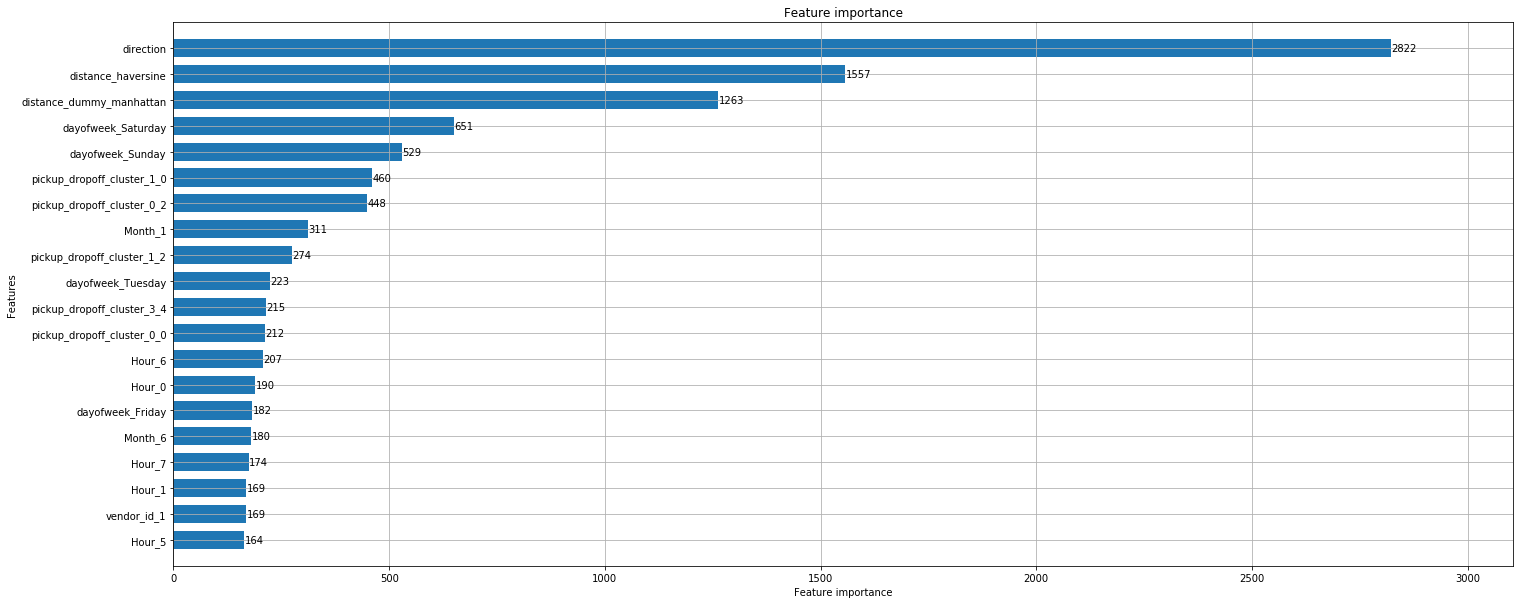

In [165]:
## lgb variable importance plot
lgb.plot_importance( lightgbm_model, max_num_features=20, height=0.7)


### model finding

Light GBM model show the similar importance selection as Xgboost Most important feature: 
- direction & distance 
- pickup and dropoff cluster pair 
- saturday and sunday


In [166]:
# save the model to disk
filename = 'model/kim_lightgbm.sav'
joblib.dump( lightgbm_model , filename)
 

['model/kim_lightgbm.sav']

## apply light-gbm model on test master data

In [180]:
## make prediction
predictions = lightgbm_model.predict(test_master)

## apply exponential transform to obtain actual duration

actual_predictions = 10**predictions




In [181]:
## create submission result
lgb_submission = pd.concat([test['id'], pd.DataFrame(actual_predictions)], axis=1)
lgb_submission.columns = ['id','trip_duration']


In [182]:
lgb_submission.head()

id  trip_duration
0  id3004672     739.130932
1  id3505355     830.328913
2  id1217141     444.431504
3  id2150126    1088.829916
4  id1598245     342.310908

In [183]:
## save to csv file
lgb_submission.to_csv("kim_submission_lightgbm_v3.csv", index=False)

# 5. summary and finding

Based on the current stage data source, we perform exploratory data analysis (EDA) and create additional feature that are useful such as dateTime and distance ( haversine & manhanttan) and tested two popular gradient boosting model( Xgboost and Light-GBM) to predict the duration of each trip


### Model performance ( log10 of trip duration (seconds) )
- Xgboost model - RMSE: 0.19023
- Light GBM model -  RMSE: 0.1901


### Model importance:
- Both xgboost and light-gbm show similar importance plot where:
    - Direction & distance (haversine and manhatan) show high importance variable
    - dayofweek_5 and dayofweek_6 refer to saturday and sunday (weekend), also a contributing factor the trip duration. As we know normally weekend will have higher traffic as compare to weekday
    
- the calculated average speed (total distance/ trip duration) not giving a good model performance and has been excluded from submission, further investigation needed 


### Actual score at kaggle competition

- Xgboost model give the best score = 0.43956, which ranked around 600th out of 1500 at public leaderboard
- Light-GBM model score = 0.4462

----  

### Stage 2 and Future work
- explore additional dataset such as weather and OSRM dataset
- feature engineering (add in more location-based feature such as location cluster, traffic density, weather and visibility and other

- model cross-validation
